In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [51]:
df = pd.read_csv("datos/data_RLC_subamortiguado.csv")

df.head()

,time,Vin,VC,I
0,0.000000e+00,-0.018129,-0.024679,2.860836e-06
1,1.428571e-10,0.732367,0.015804,4.098564e-06
2,2.857143e-10,1.389995,-0.015024,-1.712236e-06
3,4.285714e-10,2.126924,0.029634,-6.651841e-07
4,5.714286e-10,2.841193,-0.023690,1.054039e-06


<Axes: xlabel='time'>

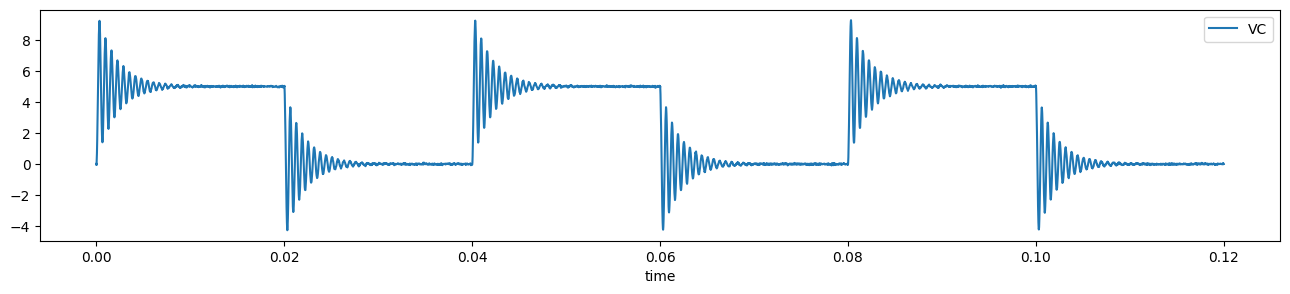

In [52]:
df.plot( x='time', y='VC', figsize=(16,3) )

<Axes: xlabel='time'>

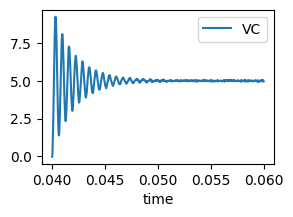

In [53]:
df_alto = df[ (df["time"]<0.06) & (df["time"]>0.04) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

In [54]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

In [55]:
R= 100
L= 100e-3
C= 100e-9

g = R/(2.0*L)
w02 = 1.0/(L*C)
w = np.sqrt(w02 - g**2 )

print (g,w)

500.0 9987.49217771909


In [56]:
def modelo_tension(u, V0, g, w):                         
    z= V0*( 1- np.exp(-g*u)*( np.cos(w*u)+ (g/w)*np.sin(w*u) ) )    # Ec para la tensión VC caso sub amort
    return z

V0_ini = 5.0
g_ini  = 100.0
w_ini  = 10000.0

In [ ]:
popt, pcov = curve_fit(modelo_tension, t, VC, p0=[ V0_ini, g_ini, w_ini ] )      

V0, g, w = popt

# Errores estandar
SE_V0, SE_g, SE_w = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f})")
print(f"g  = ({g:.4f} ± {SE_g:.6f})")
print(f"w  = ({w:.4f} ± {SE_w:.6f})")

Parámetros obtenidos del ajuste:
V0 = (4.9979 ± 0.0014)
g  = (492.0874 ± 1.095834)
w  = (9855.3184 ± 1.386273)


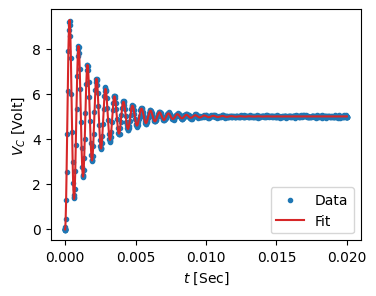

In [58]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                                    # datos

ax.plot( t, modelo_tension(t, V0, g, w), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_C$ [Volt]")

plt.legend(loc=4)
plt.show()